# TD7: Searching for steady states

The goal of this TD is to get familiar with a few techniques that allow you to find the steady states of a dynamical system from a numerical point of view.

We will be interested in the following differential equation:
$$
    \dot{x} = -x^3 + 5x + \mu,
$$
that depends on a real parameter $\mu$. Here, the steady states are simply the roots of the polynomial $f_\mu(x) = -x^3 + 5x + \mu$. Depending on the value of $\mu$, there can be one, two or three real roots.

We will need the usual Python packages:

In [1]:
# To draw matplotlib plots within this notebook.
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

## Part 1: Runge-Kutta approach: an uncomplete bifurcation diagram

A first approach to find the steady states of a dynamical system is to draw some various initial conditions and integrate the corresponding Cauchy problems for a sufficient long time. This time has to be long enough to reach a steady state, at least approximately.

*Note that in general, a solution of a dynamical system is not guaranteed to converge, but for our particular system any solution will converge to a steady state (can you see why?).*

We thus want to solve multiple Cauchy problems such as:
$$
\begin{cases}
    \dot{x} &= f_\mu (x)\\
    x (0) &= x_0
\end{cases}
$$
with $x_0$ chosen from a set of relevant values $\{x_0^{(1)}, ..., x_0^{(m)}\}$.

We will use a Runge-Kutta method to integrate these systems. We recall the RK4 method (Runge-Kutta method of fourth order) that computes the value of the numerical solution $x (t)$ as follows:
$$
\begin{align}
    X_1 &= \Delta t~f_\mu\left(x (t)\right)\\
    X_2 &= \Delta t~f_\mu\left(x(t) + \frac{X_1}{2}\right)\\
    X_3 &= \Delta t~f_\mu\left(x(t) + \frac{X_2}{2}\right)\\
    X_4 &= \Delta t~f_\mu\left(x(t) + X_3\right)\\
    x (t + \Delta t) &= x (t) + \frac1{6}(X_1 + 2X_2 + 2X_3 + X_4)
\end{align}
$$

For a given initial condition $x_0$, we will solve the Cauchy problem on $[0, T]$, with $T$ big enough to claim that the numerical solution has approximately converged. In practice, we can use the following criterion to define $T$: let $T$ be the smallest positive number such as $|f_\mu(x(T))| \leq \sigma$, with $\sigma$ an arbitrary threshold .

**1)** Define a $rk4$ function which returns the value of $x(t+\Delta t)$ in function of $x(t)$, $f$, and $\Delta t$ using the previous Runge-Kutta method.

In [2]:
def rk4(f, x0, dt):
    X1 = dt * f(x0)
    X2 = dt * f(x0 + X1/2)
    X3 = dt * f(x0 + X2/2)
    X4 = dt * f(x0 + X3)
    return x0 + (X1 + 2*X2 + 2*X3 + X4)/6

**2)** For given values of $\mu$, $x_0$ and $\sigma$, integrate the system on $[0,T]$. We will plot the corresponding solution. Give an approximate value of the steady state $x_\infty$ reached by this solution.

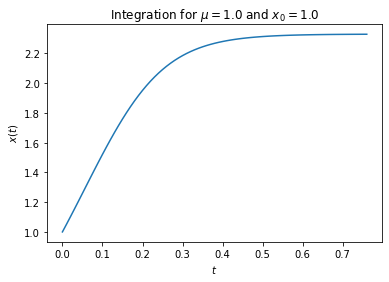

Approximation of the steady state: 2.329178196193434


In [3]:
def f_mu(mu):
    return lambda x: mu + 5*x - x**3

# Parameters of the system
mu = 1.0
x0 = 1.0

# Parameters of the integration
dt = 0.01
sigma = 0.01

# Let us define the velocity field corresponding to our value of \mu
f = f_mu(mu)

# Initial condition
xn = x0
tn = 0

# Integration
sol = []
f_val = f(xn)
sol.append([tn, xn])
while np.abs(f_val) > sigma: # Integrate until we reach convergence
    xn = rk4(f, xn, dt)
    tn += dt
    sol.append([tn, xn])
    f_val = f(xn) # For the stopping criterion
sol = np.array(sol)
    
# Plot of the solution
plt.figure()
plt.plot(sol[:, 0], sol[:, 1])
plt.xlabel('$t$')
plt.ylabel('$x(t)$')
plt.title(f"Integration for $\mu = {mu}$ and $x_0={x0}$")
plt.show()

print("Approximation of the steady state:", sol[-1, 1])

Now that we know how to integrate our system and to approximate its steady states, we want to describe the dependence of the steady states to the $\mu$ parameter. We want to build a **bifurcation diagram**, which represents the steady states $x_\infty$ as a function of $\mu$ (there can be several steady states for a given value of $\mu$ as mentioned above).

**3)** Plot the bifurcation diagram of this dynamical system. We can typically probe values of $\mu$ that range from $-10$ to $10$, and for each of these values, probe values of $x_0$ that range from $-5$ to $5$.

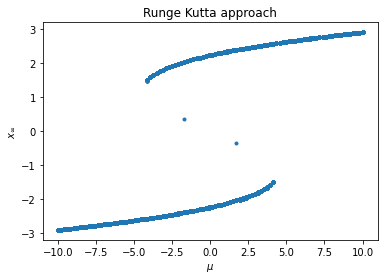

In [4]:
mu_range = np.linspace(-10, 10, 100)
x0_range = np.linspace(-5.0, 5.0, 100)

# Let us compute the bifurcation diagram
x_infty = []
for mu in mu_range:
    f = f_mu(mu)
    for x0 in x0_range:
        xn = x0
        f_val = f(xn)
        while np.abs(f_val) > sigma:
            xn = rk4(f, xn, dt)
            f_val = f(xn)
        x_infty.append([mu, xn])
x_infty = np.array(x_infty)

# Plot of the bifurcation diagram
plt.figure()
plt.scatter(x_infty[:, 0], x_infty[:, 1], marker='.')
plt.xlabel(r'$\mu$')
plt.ylabel(r'$x_\infty$')
plt.title('Runge Kutta approach')
plt.show()

**4)** Can we find all the steady states of our system for a given value of $\mu$ with this method?

<span style="color:red">**Answer:**<br/><br/>
    No we will have issues finding the unstable steady states that cannot be reached efficiently with this method.
</span>

## Part 2: Newton's method: a complete bifurcation diagram

We need another technique if we want to find the unstable steady states. **Newton's method** is a general technique that find the zeros of a function independently of how stable these zeros are in the context of a dynamical system.

For a function $f$ defined over the real numbers, starting from a real $x_0$, Newton's method converges towards a zero of $f$ through the following recurrent sequence:
$$
    x_{n+1} = x_n - \frac{f(x_n)}{f^\prime(x_n)}
$$
Obviously the choice of $x_0$ will be determinant to the limit value of the previous sequence. We will need to try several initial conditions to find every zero of $f$.

**5)** Build a *newton* routine that computes the value of $x_{n+1}$ as a function of $f$, $f^\prime$ and $x_n$.

In [5]:
def newton(f, jac_f, x0):
    return x0 - f(x0) / jac_f(x0)

**6)** Observe Newton's method quadratic convergence to a zero of $f_\mu$ polynomial printing $\left(f_\mu\left(x_n\right)\right)_n$ first terms for given values of $x_0$ and $\mu$. Do we always have a quadratic convergence of this method?

In [6]:
def jac_f_mu(mu):
    return lambda x: 5 - 3*x**2

# Number of iterations
max_iter = 10

# Parameters of the system
mu = -5.0
x0 = -3.0

f = f_mu(mu)
jac_f = jac_f_mu(mu)

# Apply Newton's method
xn = np.zeros(max_iter + 1)
xn[0] = x0
for i in range(max_iter):
    xn[i + 1] = newton(f, jac_f, xn[i])
    
print(f(xn))

[ 7.00000000e+00  8.78944403e-01  2.24708156e-02  1.60874278e-05
  8.26361202e-12 -7.10542736e-15  3.55271368e-15 -7.10542736e-15
  3.55271368e-15 -7.10542736e-15  3.55271368e-15]


<span style="color:red">We see that $|f_\mu(x_{n + 1})| \leq C |f_\mu(x_{n})|^2$ before reaching floating-point numbers maximal accuracy (machine epsilon).
</span>

**7)** Plot a new bifurcation diagram of our dynamical system using Newton's method. Does it seem complete now?

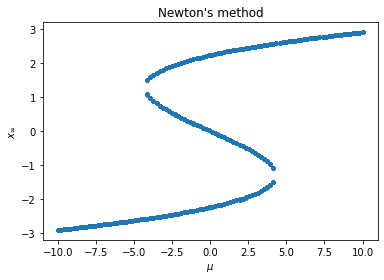

In [7]:
mu_range = np.linspace(-10, 10, 100)
x0_range = np.linspace(-5.0, 5.0, 100)

# Number of iterations
max_iter = 100

# Computation of the bifurcation diagram
x_infty = []
for mu in mu_range:
    f = f_mu(mu)
    jac_f = jac_f_mu(mu)
    for x0 in x0_range:
        cnt = 0
        xn = x0
        while np.abs(f(xn)) > sigma and cnt < max_iter:
            xn = newton(f, jac_f, xn)
            cnt = cnt + 1
        if cnt < max_iter:
            x_infty.append([mu, xn])
x_infty = np.array(x_infty)

# Plot of the bifurcation diagram
plt.figure()
plt.scatter(x_infty[:, 0], x_infty[:, 1], marker='.')
plt.xlabel(r'$\mu$')
plt.ylabel(r'$x_\infty$')
plt.title("Newton's method")
plt.show()

<span style="color:red">This bifurcation diagram is almost complete, but we still have troubles finding steady states when Newton's method does not quadratically converge, typically around $x$ values such as $f^\prime (x) = 0$.
</span>

## Bonus part: The Newton fractal

The [Newton fractal](https://en.wikipedia.org/wiki/Newton_fractal) is a fractal figure which stems from the application of Newton's method to the following complex polynomial:
$$
    f(z) = z^3 - 1
$$
The roots of the previous polynomial are well known, these are the third roots of unity: $\{1, e^{\frac{2i\pi}{3}}, e^{-\frac{2i\pi}{3}}\}$. Still, it is interesting to approximate these roots with a Newton's method applied to a regulard grid of initial values in the complex plane as spectacular properties of convergence come out from Newton's algorithm.

In the following, we will identify $\mathbb{C}$ to $\mathbb{R}^2$ for pedagogical purposes. Therefore Newton's method is to be applied to a function $f:\mathbb{R}^2\rightarrow\mathbb{R}^2$ defined as follows:
$$
    f (x, y) = \left( \begin{array}{c} f_1 (x,y) \\ f_2 (x,y)\end{array}\right) = \left( \begin{array}{c} \Re\left(\left(x+iy\right)^3 - 1\right) \\ \Im\left(\left(x+iy\right)^3 - 1\right)\end{array}\right)
$$
where $\Re$ and $\Im$ respectively denotes the real and imaginary part of a given complex number.

For a vector-valued function such as above $f$ function, Newton's method can be written as follows:
$$
    X_{n+1} = X_n - \left[\text{D}f(X_n)\right]^{-1}f(X_n)
$$
where $X_n$ is a vector (of dimension 2 for above $f$ function) and $\text{D}f(X_n)$ is the Jacobian matrix of $f$ at $X_n$. We recall the general expression of the Jacobian matrix for a function $f:\mathbb{R}^m\rightarrow\mathbb{R}^m$:
$$
    \text{D}f(X) = \left(\frac{\partial f_i}{\partial x_j}(X)\right)_{i, j\in\{1,...,m\}}
$$

**8)** What are the analytical expressions of $f$ and $\text{D}f$?

<span style="color:red">Answer:<br><br/>
    We find:
    $$
        f (x,y) = \left( \begin{array}{c} x^3 - 3xy^2 - 1 \\ -y^3+3x^2y\end{array}\right) \text{ and } \text{D}f(X) = \left( \begin{array}{cc} 3x^2 - 3y^2 & -6xy\\ 6xy & 3x^2-3y^2\end{array}\right)
    $$
</span>

**9)** Perform Newton's method on $f$ for a dense enough 2D grid of initial conditions and for a uniform number of Newton iterations. We will use [scipy.linalg.inv](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.inv.html) function to invert the Jacobian matrix.

In [8]:
import scipy.linalg as la

def f(X):
    ret = np.zeros(2)
    ret[0] = X[0]**3 - 3*X[0]*X[1]**2 - 1
    ret[1] = - X[1]**3 + 3*X[0]**2*X[1]
    return ret

def jac_f(X):
    ret = np.zeros((2, 2))
    ret[0, 0] = 3*X[0]**2 - 3*X[1]**2
    ret[0, 1] = -6*X[0]*X[1]
    ret[1, 0] = 6*X[0]*X[1]
    ret[1, 1] = -3*X[1]**2 + 3*X[0]**2
    return ret
    
def newton(f, jac_f, X0):
    return X0 - la.inv(jac_f(X0))@f(X0)

def is_close_to_roots(X, threshold):
    z = X[0] + 1j*X[1]
    if np.abs(z - 1) < threshold:
        return True
    elif np.abs(z - np.exp(1j*2*np.pi/3)) < threshold:
        return True
    elif np.abs(z - np.exp(-1j*2*np.pi/3)) < threshold:
        return True
    return False


N = 1000
x_range = np.linspace(-1, 1, N)
y_range = np.linspace(-1, 1, N)

# Build a grid
x_grid, y_grid = np.meshgrid(x_range, y_range)
c_grid = np.zeros(x_grid.shape)

max_iter = 20
threshold = 0.01

# Perform Newton's method on our grid of initial conditions
for i in range(x_grid.shape[0]):
    for j in range(x_grid.shape[1]):
        X_infty = np.array([x_grid[i, j], y_grid[i, j]])
        cnt = 0
        while not (is_close_to_roots(X_infty, threshold)) and cnt < max_iter:
            X_infty = newton(f, jac_f, X_infty)
            cnt = cnt + 1
        if cnt < max_iter: # We have converged
            c_grid[i, j] = np.angle(X_infty[0] + 1j*X_infty[1])
        else: # We do not have converged!
            c_grid[i, j] = 4.0

**10)** Plot using [pcolor](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.pcolor.html) function for each point of the previous grid of initial conditions the complex argument of the final term of the Newton sequence (we can use [numpy.angle](https://docs.scipy.org/doc/numpy/reference/generated/numpy.angle.html) function to do that). You should observe a fractal figure called the *Newton fractal*. Does Newton's method always converge in this case?

/home/bruno/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


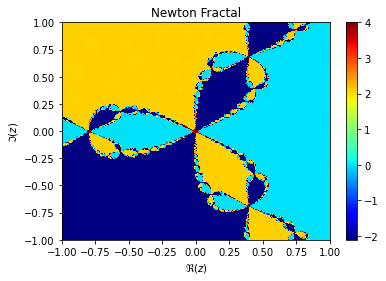

In [9]:
plt.figure()
plt.pcolor(x_grid, y_grid, c_grid, cmap='jet')
plt.xlabel('$\Re(z)$')
plt.ylabel('$\Im(z)$')
plt.title('Newton Fractal')
plt.colorbar()
plt.show()